# EDA Process

In [1]:
# Exportar modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
#Carga CSV
df_movies = pd.read_csv('movies_etl.csv', encoding='utf-8')

In [3]:
df_movies.head()

,budget,genres,id,original_language,overview,popularity,release_date,revenue,runtime,status,...,title,vote_average,vote_count,collection,companies,country,language,return,year,director
0,30000000.0,"Animation, Comedy, Family",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,...,toy story,7.7,5415.0,toy story collection,pixar animation studios,united states of america,English,12.451801,1995,john lasseter
1,65000000.0,"Adventure, Fantasy, Family",8844,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,...,jumanji,6.9,2413.0,NaN,"tristar pictures, teitler film, interscope com...",united states of america,"English, Français",4.043035,1995,joe johnston
2,0.0,"Romance, Comedy",15602,en,A family wedding reignites the ancient feud be...,11.712900,1995-12-22,0.0,101.0,Released,...,grumpier old men,6.5,92.0,grumpy old men collection,"warner bros., lancaster gate",united states of america,English,0.000000,1995,howard deutch
3,16000000.0,"Comedy, Drama, Romance",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,81452156.0,127.0,Released,...,waiting to exhale,6.1,34.0,NaN,twentieth century fox film corporation,united states of america,English,5.090760,1995,forest whitaker
4,0.0,Comedy,11862,en,Just when George Banks has recovered from his ...,8.387519,1995-02-10,76578911.0,106.0,Released,...,father of the bride part ii,5.7,173.0,father of the bride collection,"sandollar productions, touchstone pictures",united states of america,English,0.000000,1995,charles shyer


In [4]:
#Eliminamos columnas irrelevantes para un sistema de recomendacion
df_movies = df_movies.drop(columns=['id', 'release_date','status','return'])

## Valores Nulos

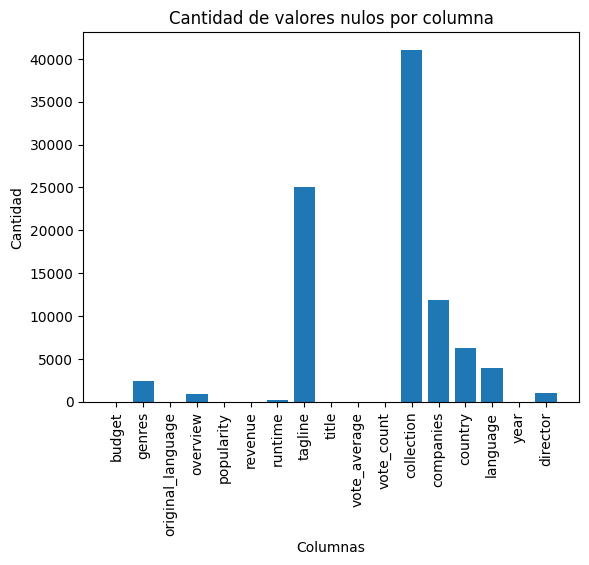

In [5]:
#Obtenemos todos los nulos de cada columna
nulos = df_movies.isnull().sum()

#Creamos un grafico de barras
plt.bar(nulos.index, nulos.values)
plt.xlabel('Columnas')
plt.ylabel('Cantidad')
plt.title('Cantidad de valores nulos por columna')
plt.xticks(rotation=90)
plt.show()

In [6]:
#Elimacion de columnas con mayor cantidad de nulos
df_movies = df_movies.drop(columns=['tagline', 'collection','country','language'])


- Hacemos una excepcion para 'companies' ya que puede ser un buen indicador de similitud para un sistema de recomendacion, ya que 'collection' posee demasiados valores nulos.

In [7]:
#Manejo de valores nulos por un caracter vacio en str y 0 en float
df_movies['genres'] = df_movies['genres'].fillna('').astype(str).str.lower()
df_movies['original_language'] = df_movies['original_language'].fillna('').astype(str)
df_movies['overview'] = df_movies['overview'].fillna('').astype(str).str.lower()
df_movies['director'] = df_movies['director'].fillna('').astype(str).str.lower()
df_movies['companies'] = df_movies['companies'].fillna('').astype(str).str.lower()
df_movies['runtime'] = df_movies['runtime'].fillna(0)

In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45451 entries, 0 to 45450
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             45451 non-null  float64
 1   genres             45451 non-null  object 
 2   original_language  45451 non-null  object 
 3   overview           45451 non-null  object 
 4   popularity         45451 non-null  float64
 5   revenue            45451 non-null  float64
 6   runtime            45451 non-null  float64
 7   title              45451 non-null  object 
 8   vote_average       45451 non-null  float64
 9   vote_count         45451 non-null  float64
 10  companies          45451 non-null  object 
 11  year               45451 non-null  int64  
 12  director           45451 non-null  object 
dtypes: float64(6), int64(1), object(6)
memory usage: 4.5+ MB


## Visualizacion de campos numericos

In [9]:
df_movies.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,year
count,4.545100e+04,45451.000000,4.545100e+04,45451.000000,45451.000000,45451.000000,45451.000000
mean,4.231294e+06,2.926887,1.121930e+07,93.672152,5.624085,109.989703,1991.882027
std,1.742942e+07,6.006458,6.433984e+07,38.845201,1.915424,491.352336,24.057726
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1874.000000
25%,0.000000e+00,0.389095,0.000000e+00,85.000000,5.000000,3.000000,1978.000000
50%,0.000000e+00,1.131386,0.000000e+00,95.000000,6.000000,10.000000,2001.000000
75%,0.000000e+00,3.694370,0.000000e+00,107.000000,6.800000,34.000000,2010.000000
max,3.800000e+08,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000


- Podemos observar que las columnas 'budget' y 'revenue' se encuentran sumamente sesgadas ya que la mayoria de sus valores estan alejados del maximo. Asi tambien la columna 'popularity' 

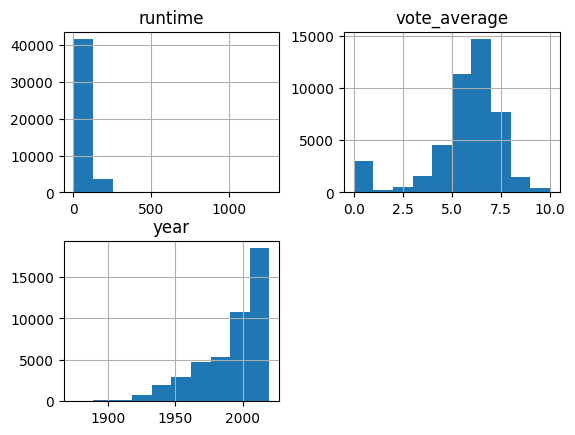

In [10]:
#Histograma para valores no tan sesgados
df_movies[['runtime','vote_average','year']].hist(bins=10)
plt.show()

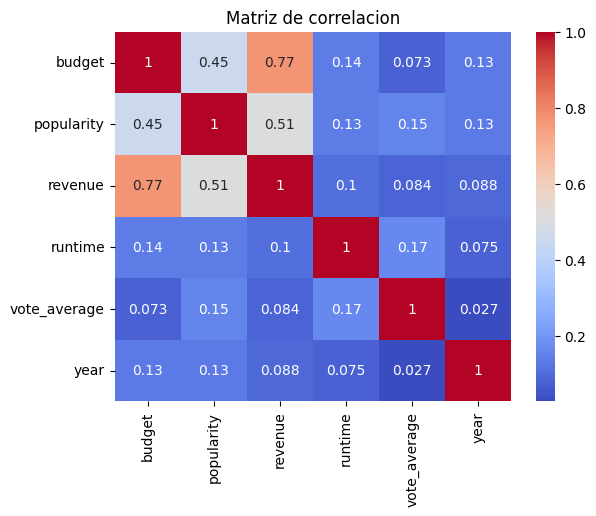

In [11]:
#Matriz de correlacion 
matriz = df_movies[['budget','popularity','revenue','runtime','vote_average','year']].corr()
sns.heatmap(matriz, annot=True, cmap='coolwarm')
plt.title('Matriz de correlacion')
plt.show()

- Podemos observacion que existe una correlacion positiva entre 'popularity, 'budget' y 'revenue'. Ademas la alta correlacion entre 'budget' y 'revenue', de modo que no tiene sentido evaluar estos campos en conjunto.<br>
Podemos inferir que el presupuesto esta asociado a la ganancia pero podriamos observar la relacion con la popularidad.

/home/hernan/Escritorio/IndividualProject/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/hernan/Escritorio/IndividualProject/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


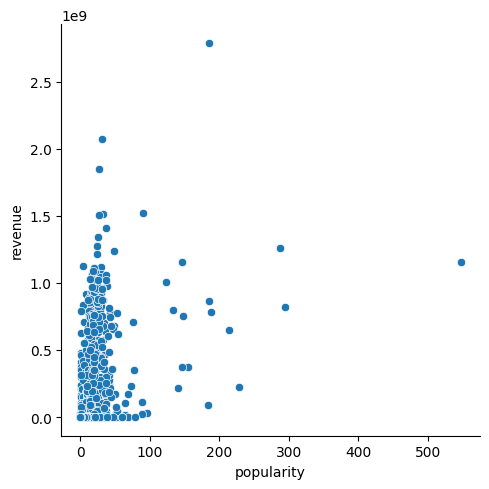

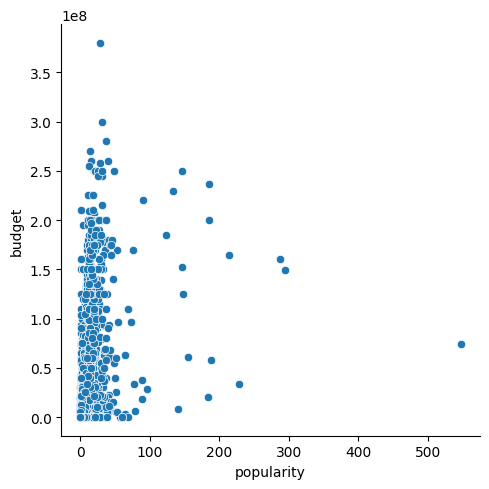

In [12]:
#Grafico de dispersion para observar la relacion
sns.relplot(data=df_movies, x='popularity', y='revenue')
sns.relplot(data=df_movies, x='popularity', y='budget')

- Dado los datos no podemos inferir nada acerca de esta correlacion.

In [13]:
#Exportamos el CSV para ser consumido en el ML
if not os.path.isfile('movies_eda.csv'):
    df_movies.to_csv('movies_eda.csv', index=False)
    print('Archivo movies_eda.csv creado')
else:
    print('Archivo existente')

Archivo existente


# ML Process

Para poder brindar un sistema de recomendacion, debemos tener en cuenta: 
- Calificaciones y resenias: es decir que tenemos que tener en cuenta el puntaje de cada pelicula pero tambien que cantidad de votos tiene para llegar a ese puntaje.

In [14]:
#Filtramos las filas a recomendar
df_filtered = df_movies[df_movies['vote_count'] > 30]
df_sorted = df_filtered.sort_values('vote_average', ascending=False).head(10000).reset_index(drop=True)

- Genero: debe estar obligatoriamente en la recomendacion.
- Overview: tras el uso de palabras clave se puede identificar peliculas con similares.
- Companies: existen muchos casos donde las companias hacen genero similares de peliculas.  

In [15]:
#Creamos un campo compuesto por otros campos seleccionados
df_sorted['str_vector'] = df_sorted['genres'] + ' ' + df_sorted['overview'] + ' ' + df_sorted['companies']  
df_sorted = df_sorted[['title', 'str_vector','vote_average']]

In [16]:
#Vectorizamos el campo compuesto
vectorizer = TfidfVectorizer(max_features=5000)
matriz_vector = vectorizer.fit_transform(df_sorted['str_vector'])

In [17]:
#Hacemos uso del metodo de similitud de cosenos para hallar valores similares
cos_sim = cosine_similarity(matriz_vector)

In [18]:
#Funcion de ingreso de titulo y retorno de recomendacion 
def recomendacion(titulo):
    titulo = titulo.lower()
    if titulo in df_sorted['title'].values:
        indices = pd.Series(df_sorted.index, index=df_sorted['title']).drop_duplicates()
        idx = indices[titulo]
        scores = list(enumerate(cos_sim[idx]))
        scores = sorted(scores, key=lambda x:x[1], reverse=True)
        top_indices = [i[0] for i in scores if i[0] !=idx]

        top_movies = df_sorted['title'].iloc[top_indices[:5]]
        recomended_movies = ', '.join(top_movies)
        return {'peliculas recomendadas': recomended_movies}
    else:
        return 'La pelicula no se encuentra dentro de la muestra'
   

In [19]:
recomendacion('fast five')

{'peliculas recomendadas': 'fast & furious, the fast and the furious, life of brian, fast & furious 6, 2 fast 2 furious'}